# Community Selection 
This tutorial provides an minimal example for conducting community-level selection with given selection algorthms.

In [1]:
from IPython.display import Image
from community_simulator import *
from community_simulator.usertools import *
from community_simulator.visualization import *
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends import backend_pdf as bpdf
import numpy as np
import scipy as sp
colors = sns.color_palette()
%matplotlib inline

# Community selection module
from community_selection import *
from community_selection.A_experiment_functions import *
from community_selection.B_community_phenotypes import *
from community_selection.C_selection_algorithms import *
from community_selection.D_migration_algorithms import *

cvxpy not installed. Community.SteadyState() not available.


# Library of algorithms
List of algorithms

In [2]:
make_algorithm_library()

,AlgorithmType,AlgorithmName
0,community_phenotype,resource_distance_community_function
1,community_phenotype,community_function_additive
2,community_phenotype,community_function_additive_saturation
3,community_phenotype,community_function_complex
4,community_phenotype,community_function_complex_saturation
5,community_phenotype,resource_additive
6,community_phenotype,resource_additive_saturation
7,community_phenotype,resource_additive
8,community_phenotype,resource_complex_saturation
0,selection_algorithm,select_best_n


# Examples
1. Set up parameters 
2. Make inital state and put together consumer and resource initial states into a plate
3. Simulate the community

Set up the simulation parameters 

In [3]:
# Make dynanmics by default we will use the microbial consumer resource model
def dNdt(N,R,params):
    return MakeConsumerDynamics(assumptions)(N,R,params)
def dRdt(N,R,params):
    return MakeResourceDynamics(assumptions)(N,R,params)
dynamics = [dNdt,dRdt]

# Assumptions
assumptions = a_default.copy() # Start with default parameters
assumptions.update({'n_wells':96, 'c1' :0.01, 'muc':0.1, 'm':0}) # Switch off mortality

# Prepare experiment; 
params, species_pool = prepare_experiment(assumptions)

## Simulation parameters
params_simulation = {
    "n_propagation": 24, # Length of propagation, or hours within a growth cycle
    "n_transfer": 5, # Number of transfer, or number of passage
    "dilution": 1/1000, # Dilution factor for transfer
    "pool": species_pool
}

# Control

In [4]:
# Make initial state
init_state = MakeInitialState(assumptions)
# Make plate
plate = Community(init_state, dynamics, params, scale = 10**6, parallel = True) 
# Choose the selection algorithms to run
params_algorithm = {"community_phenotype": "community_function_additive", "selection_algorithm": "no_selection", "migration_algorithm": "no_migration"}
# Simulation
ctrl_plate_df, ctrl_function_df = simulate_community(plate, params_simulation, params_algorithm, write_composition = False)

Transfer 1 done.
Transfer 2 done.
Transfer 3 done.
Transfer 4 done.
Transfer 5 done.


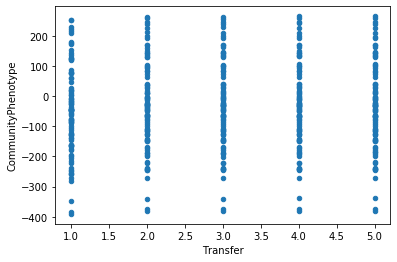

In [5]:
plot_community_function(ctrl_function_df)

## Selection
Select top 25% for example

In [6]:
# Make initial state
init_state = MakeInitialState(assumptions)
# Make plate
plate = Community(init_state, dynamics, params, scale = 10**6, parallel = True) 
# Choose the selection algorithms to run
params_algorithm = {"community_phenotype": "community_function_additive", "selection_algorithm": "select_best_n", "migration_algorithm": "no_migration"}
# Simulation
selection_plate_df, selection_function_df = simulate_community(plate, params_simulation, params_algorithm, write_composition = False)

Transfer 1 done.
Transfer 2 done.
Transfer 3 done.
Transfer 4 done.
Transfer 5 done.


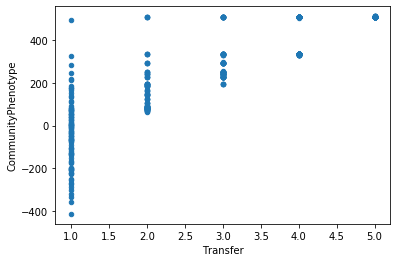

In [7]:
plot_community_function(selection_function_df)